In [1]:
# read the data queried in the last module

from astropy.table import Table

filename = 'gd1_data.fits'
results = Table.read(filename)
results.info


<Table length=140339>
   name    dtype    unit                              description                                class    
--------- ------- -------- ------------------------------------------------------------------ ------------
source_id   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn
       ra float64      deg                                                    Right ascension       Column
      dec float64      deg                                                        Declination       Column
     pmra float64 mas / yr                         Proper motion in right ascension direction       Column
    pmdec float64 mas / yr                             Proper motion in declination direction       Column
 parallax float64      mas                                                           Parallax       Column

Text(0, 0.5, 'dec (degree IRCS)')

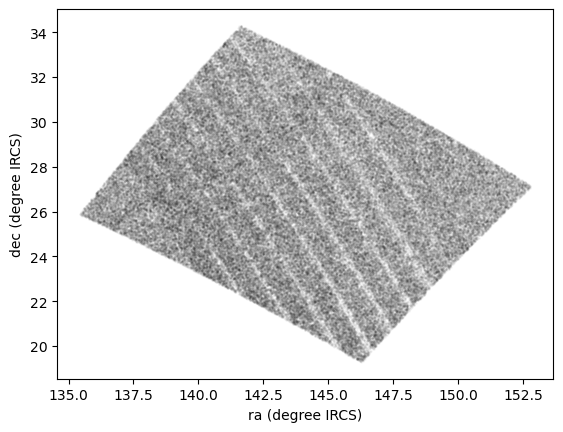

In [3]:
# render a plot of the data in ICRS

import matplotlib.pyplot as plt

x = results['ra']
y = results['dec']

plt.plot(x,y,'ko', alpha=0.03, markersize=1)
plt.xlabel('ra (degree IRCS)')
plt.ylabel('dec (degree IRCS)')


In [5]:
# transform back to the GD1 frame

import astropy.units as u
from astropy.coordinates import SkyCoord
from gala.coordinates import GD1Koposov10
from gala.coordinates import reflex_correct


distance = 8 * u.kpc
radial_velocity = 0 * u.km/u.s

skycoord_icrf = SkyCoord(ra=results['ra'], 
                    dec=results['dec'],
                    pm_ra_cosdec=results['pmra'],
                    pm_dec=results['pmdec'], 
                    distance=distance, 
                    radial_velocity=radial_velocity)

gd1_frame = GD1Koposov10()
transformed = skycoord_icrf.transform_to(gd1_frame)
skycoord_gd1 = reflex_correct(transformed)



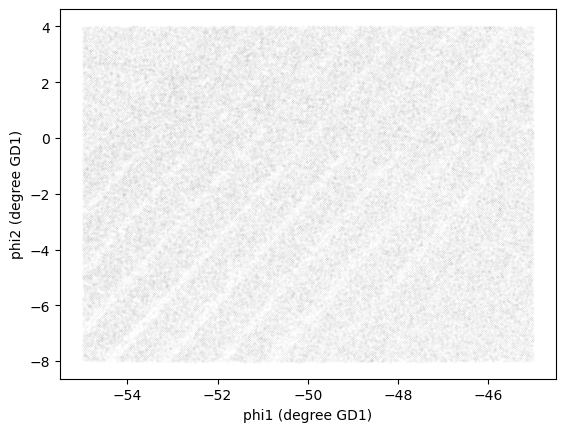

In [20]:
# and re-render
x = skycoord_gd1.phi1
y = skycoord_gd1.phi2
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)');


In [ ]:
# now bring the data into a Pandas dataframe

import pandas as pd

# units are not preserved in this transition to Pandas
# is there a better way ???
results_df = results.to_pandas()

# strip units ???
results_df['phi1'] = skycoord_gd1.phi1.value
results_df['phi2'] = skycoord_gd1.phi2.value
results_df['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2.value
results_df['pm_phi2'] = skycoord_gd1.pm_phi2.value

#results_df.describe()
#results_df.head()


<module 'matplotlib.pyplot' from '/home/adamarthurryan/micromamba/envs/jupyter/lib/python3.13/site-packages/matplotlib/pyplot.py'>

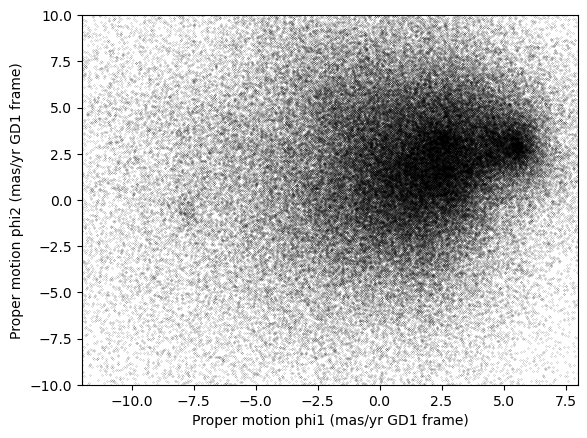

In [ ]:
def plot_proper_motion(df) :
    """Plot propermotion in GD1 coordinates from given dataframe"""
    x = df['pm_phi1']
    y = df['pm_phi2']
    plt.plot(x, y, 'ko', markersize=0.1, alpha=1)
        
    plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
    plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)');

    plt.xlim(-12, 8)
    plt.ylim(-10, 10);

    return plt

plot_proper_motion(results_df)

In [68]:
results_df.describe()

,source_id,ra,dec,pmra,pmdec,parallax,phi1,phi2,pm_phi1,pm_phi2
count,1.403390e+05,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000
mean,6.792399e+17,143.823122,26.780285,-2.484404,-6.100777,0.179492,-50.091158,-1.803301,-0.868963,1.409208
std,3.792177e+16,3.697850,3.052592,5.913939,7.202047,0.759590,2.892344,3.444398,6.657714,6.518615
min,6.214900e+17,135.425699,19.286617,-106.755260,-138.065163,-15.287602,-54.999989,-8.029159,-115.275637,-161.150142
25%,6.443517e+17,140.967966,24.592490,-5.038789,-8.341561,-0.035981,-52.602952,-4.750426,-2.948723,-1.107128
50%,6.888060e+17,143.734409,26.746261,-1.834943,-4.689596,0.362708,-50.147362,-1.671502,0.585037,1.987149
75%,6.976579e+17,146.607350,28.990500,0.452893,-1.937809,0.657637,-47.593279,1.160514,3.001768,4.628965
max,7.974418e+17,152.777393,34.285481,104.319923,20.981070,0.999957,-44.999985,4.014609,39.802471,79.275199


<module 'matplotlib.pyplot' from '/home/adamarthurryan/micromamba/envs/jupyter/lib/python3.13/site-packages/matplotlib/pyplot.py'>

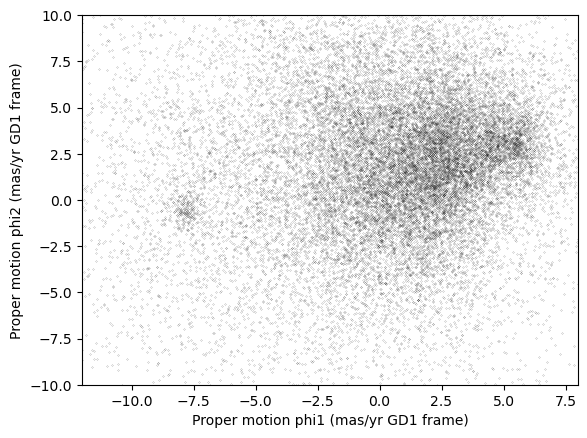

In [73]:
# filter to stars more likely to be in GD1 population

# get the phi2 series
phi2 = results_df["phi2"]

# create a mask of values in range of +/- 1 deg from centerline
phi2_range = (-1.0*u.degree, 1.0*u.degree)
mask = (phi2 > phi2_range[0]) & (phi2 < phi2_range[1])

# filter the results
centerline_df = results_df[mask]

#centerline_df.describe()
plot_proper_motion(centerline_df)

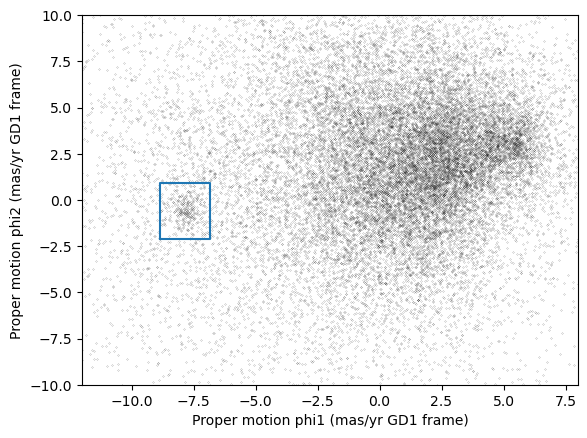

In [78]:
# identifying the small overdense region around (-7.5, 0.0)
pm1_range = (-8.85,-6.85)
pm2_range = (-2.1, 0.9) 

def make_rectangle(x1, x2, y1, y2):
    """Return the corners of a rectangle."""
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    return xs, ys

pm1_rect, pm2_rect = make_rectangle(pm1_range[0], pm1_range[1], pm2_range[0], pm2_range[1])

plot_proper_motion(centerline_df)
plt.plot(pm1_rect, pm2_rect, '-')


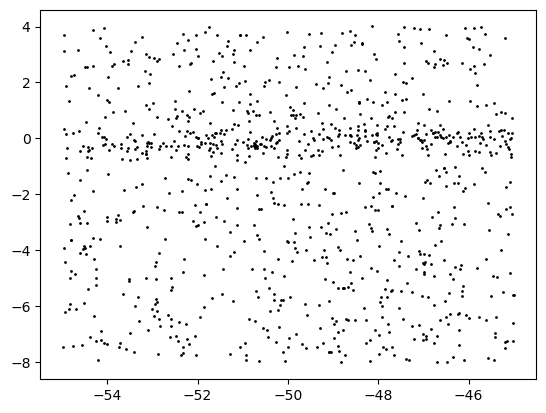

In [ ]:
# now filter the dataframe based on those coordinates

pm1 = results_df['pm_phi1']
pm2 = results_df['pm_phi2']

def between(series, range):
    (low,high) = range
    """Check whether values are between `low` and `high`."""
    return (series > low) & (series < high)

mask = between(pm1, pm1_range) & between(pm2, pm2_range)

ds1_df = results_df[mask]

phi1 = ds1_df['phi1']
phi2 = ds1_df['phi2']

plt.plot(phi1,phi2, 'ko', markersize=1, alpha=1)

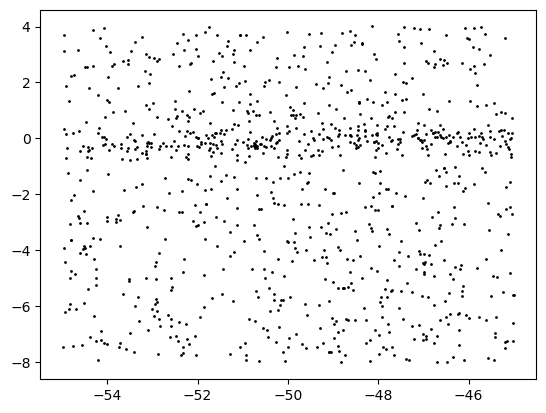

In [10]:

# try again but just sticking with astropy
results_tbl = results
results_tbl['phi1'] = skycoord_gd1.phi1
results_tbl['phi2'] = skycoord_gd1.phi2
results_tbl['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
results_tbl['pm_phi2'] = skycoord_gd1.pm_phi2 

# create the centerline table
# get the phi2 series
phi2 = results_tbl["phi2"]
# create a mask of values in range of +/- 1 deg from centerline
phi2_range = (-1.0*u.degree, 1.0*u.degree)
mask = (phi2 > phi2_range[0]) & (phi2 < phi2_range[1])
# filter the results
centerline_tbl = results_tbl[mask]

# create the selection table 
pm1 = results_tbl['pm_phi1']
pm2 = results_tbl['pm_phi2']
pm1_range = (-8.85,-6.85)
pm2_range = (-2.1, 0.9) 


mask = between(pm1, pm1_range) & between(pm2, pm2_range)

selection_tbl = results_tbl[mask]

phi1 = selection_tbl['phi1']
phi2 = selection_tbl['phi2']


plt.plot(phi1,phi2, 'ko', markersize=1, alpha=1)

In [14]:
# write the astropy version of the data

filename = 'gd1_data_03.hdf5'
selection_tbl.write(filename, path="selection", serialize_meta=True, overwrite=True)
centerline_tbl.write(filename, path="centerline", serialize_meta=True, append=True)
from os.path import getsize
MB = 1024*1024
getsize(filename)/MB

2.005735397338867